<a href="https://colab.research.google.com/github/272572PPiwnicki/fourier/blob/main/transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from abc import abstractmethod
from typing import Optional

import numpy as np
import pywt
from numpy.typing import NDArray


class CompressionTransform:
    """
    Interface for compression transforms.
    """

    @abstractmethod
    def forward(self, variables: NDArray) -> NDArray:
        ...

    @abstractmethod
    def backward(self, variables: NDArray) -> NDArray:
        ...


class FourierTransform2D(CompressionTransform):
    """
    2D Fourier transform used for compression.
    Inverse transform uses absolute value by default.
    """

    def forward(self, variables: NDArray) -> NDArray:
        return np.fft.fft2(variables)

    def backward(self, variables: NDArray) -> NDArray:
        return np.abs(np.fft.ifft2(variables))


class WaveletTransform2D(CompressionTransform):
    """
    2D wavelet transform used for compression.
    """

    def __init__(self, wavelet_name: str, level: int):
        self.wavelet_name = wavelet_name
        self.level = level
        self.slices: Optional[NDArray] = None

    def forward(self, variables: NDArray) -> NDArray:
        transformed = pywt.wavedec2(variables, self.wavelet_name, level=self.level)
        coefficients, slices = pywt.coeffs_to_array(transformed)
        self.slices = slices

        return coefficients

    def backward(self, variables: NDArray) -> NDArray:
        if self.slices is None:
            raise ValueError("Cannot perform inverse transform without first performing forward transform!")

        variables = pywt.array_to_coeffs(variables, self.slices, output_format="wavedec2")  # type: ignore
        return pywt.waverec2(variables, self.wavelet_name)


def compress_and_decompress(image: NDArray, transform: CompressionTransform, compression: float) -> NDArray:
    """
    Compresses and decompresses an image using the Fourier transform.
    This function can be used to see compression and decompression effects.

    :param image: greyscale image
    :param transform: transform to use, using CompressionTransform interface
    :param compression: ratio of coefficients to remove

    :return: image after compression and decompression
    """
    transformed = transform.forward(image)
    coefficients = np.sort(np.abs(transformed.reshape(-1)))  # sort by magnitude

    threshold = coefficients[int(compression * len(coefficients))]
    indices = np.abs(transformed) > threshold

    decompressed = transformed * indices
    return transform.backward(decompressed)

In [ ]:
import numpy as np
from numpy.typing import NDArray


def apply_rgb(func: callable, image: NDArray, *args, **kwargs) -> NDArray:
    """
    Applies a function to each color channel of an image.

    :param func: function to apply to each color channel
    :param image: image to apply function to

    :return: image after function has been applied to each color channel
    """
    return np.dstack([func(image[:, :, channel], *args, **kwargs) for channel in range(3)])

In [ ]:
import sys

import os

import numpy as np
import pandas as pd
from skimage import color, io, measure
from matplotlib import pyplot as plt
from sklearn import metrics, preprocessing, linear_model

In [ ]:
image = io.imread("namib.jpg")

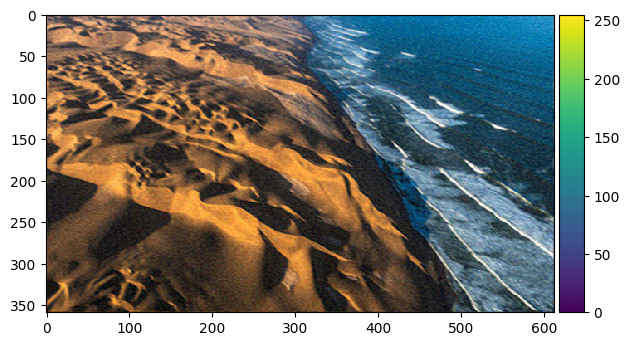

In [ ]:
decompressed_image = apply_rgb(compress_and_decompress, image, transform=FourierTransform2D(), compression=0.90)
_ = io.imshow(np.clip(decompressed_image.astype(int), 0, 255))

In [ ]:
summary = []

for compression in (0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.98, 0.99, 0.999):
        decompressed_image = apply_rgb(compress_and_decompress, image, transform=FourierTransform2D(), compression=compression)
        decompressed_image = np.clip(decompressed_image.astype(int), 0, 255)
        error = metrics.mean_absolute_error(y_true=image.flatten(), y_pred=decompressed_image.flatten()) / image.max()
        summary.append({"image": "namib.jpg", "compression": compression, "error": error})

In [ ]:
pd.DataFrame.from_dict(summary).head(10)

,image,compression,error
0,namib.jpg,0.000,0.001956
1,namib.jpg,0.100,0.003411
2,namib.jpg,0.300,0.010061
3,namib.jpg,0.500,0.017525
4,namib.jpg,0.700,0.026180
5,namib.jpg,0.900,0.039735
6,namib.jpg,0.950,0.047023
7,namib.jpg,0.980,0.056204
8,namib.jpg,0.990,0.063845
9,namib.jpg,0.999,0.091063


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


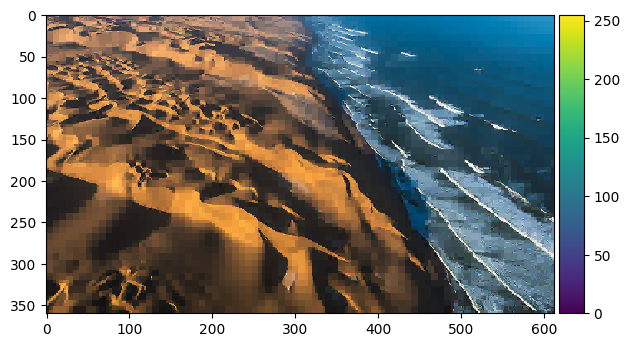

In [ ]:
decompressed_image = apply_rgb(compress_and_decompress, image, transform=WaveletTransform2D(wavelet_name="db1", level=3), compression=0.95)
_ = io.imshow(np.clip(decompressed_image.astype(int), 0, 255))